In [1]:
%load_ext autoreload
%autoreload 2

import sys

sys.path.append("..")
import numpy as np
import torch
import random
from tqdm import tqdm

import matplotlib.pyplot as plt

from src.datasets import data, utils, configs
from src.datasets.utils import dump_generated_dataset, PreGeneratedDataset
from src.models import base_models, slot_attention
import os
from src import metrics

from torchvision import transforms as transforms

seed = 43
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

from utils.decoder_evaluation import calculate_decoder_optimality, get_left_right_datasets, scale, min_offset
from utils.heatmap_utils import cast_models_to_device, evaluate_function_over_seeds, load_model_and_hook
import pickle

import seaborn as sns

In [2]:
# Step 1: Creating color traversing

n_steps = 100

c_0_range = torch.linspace(0.05, 0.95, n_steps)
c_0_combinations = torch.cartesian_prod(c_0_range, c_0_range)

distances = torch.sqrt((c_0_combinations[:, 0] - c_0_combinations[:, 1]) ** 2)

id_c_0_combinations = c_0_combinations[distances <= 0.125 * 2]
ood_c_0_combinations = c_0_combinations[distances > 0.125 * 2]


In [3]:
# # Step 2: Generate initial ID and OOD
# cfg = configs.SpriteWorldConfig()

# initial_id_latents = torch.load("D:/mnt/qb/heatmap_dataset/initial_id_latents.pt")
# initial_id_latents = initial_id_latents[:len(id_c_0_combinations)]



# initial_ood_latents = torch.load("D:/mnt/qb/heatmap_dataset/initial_ood_latents.pt")
# initial_ood_latents = initial_ood_latents[:len(ood_c_0_combinations)]

In [4]:
# # # Step 3: Generate versions
# def create_dataset_versions(latents, color_replacement, save_folder, n_versions=5):
#     for i in range(5):
#         # copy latents
#         local_copy = latents.clone()
        
#         # create permutation
#         perm = torch.randperm(local_copy.size(0))
#         shuffled_local_copy = local_copy[perm]
        
#         # replace color dimension
#         shuffled_local_copy[:, :, -3] = color_replacement
            
#         # generate data
#         dataset = data.SpriteWorldDataset(
#                     len(latents),
#                     2,
#                     cfg,
#                     sample_mode="skip",
#                     no_overlap=True,
#                     delta=0.125,
#                     transform=transforms.Compose([transforms.ToPILImage(), transforms.ToTensor()]),
#                     z=shuffled_local_copy
#         )
        
#         os.makedirs(f"{save_folder}/dataset_{i}/", exist_ok=True)
#         # dump data
#         dump_generated_dataset(dataset, f"{save_folder}/dataset_{i}/")
        
# create_dataset_versions(initial_id_latents, id_c_0_combinations, "D:/mnt/qb/heatmap_dataset/id_data/")
# create_dataset_versions(initial_ood_latents, ood_c_0_combinations, "D:/mnt/qb/heatmap_dataset/ood_data/")

Generating images (sampling: skip): 100%|█████████████████████████████████████████| 4744/4744 [00:42<00:00, 112.12it/s]
4744it [00:00, 7821.10it/s]
Generating images (sampling: skip): 100%|█████████████████████████████████████████| 4744/4744 [00:40<00:00, 118.44it/s]
4744it [00:00, 11139.44it/s]
Generating images (sampling: skip): 100%|█████████████████████████████████████████| 4744/4744 [00:42<00:00, 111.25it/s]
4744it [00:00, 7410.50it/s] 
Generating images (sampling: skip): 100%|█████████████████████████████████████████| 4744/4744 [00:41<00:00, 115.53it/s]
4744it [00:00, 10026.93it/s]
Generating images (sampling: skip): 100%|█████████████████████████████████████████| 4744/4744 [00:39<00:00, 121.63it/s]
4744it [00:00, 11360.71it/s]
Generating images (sampling: skip): 100%|█████████████████████████████████████████| 5256/5256 [00:42<00:00, 122.70it/s]
5256it [00:00, 10001.75it/s]
Generating images (sampling: skip): 100%|█████████████████████████████████████████| 5256/5256 [00:46<00:00,

In [5]:
# # # Step 4: Dump left and right dataset
# n_versions = 5
# save_folder_id = "D:/mnt/qb/heatmap_dataset/id_data"
# save_folder_ood = "D:/mnt/qb/heatmap_dataset/ood_data"
# for i in range(n_versions):
#     ood_data = PreGeneratedDataset(f"{save_folder_ood}/dataset_{i}")
#     id_data = PreGeneratedDataset(f"{save_folder_id}/dataset_{i}")

#     id_diagonal_dataset_left, id_diagonal_dataset_right = get_left_right_datasets(id_data)
#     ood_diagonal_dataset_left, ood_diagonal_dataset_right = get_left_right_datasets(ood_data)

#     dump_generated_dataset(id_diagonal_dataset_left, f"{save_folder_id}/dataset_{i}/left/")
#     dump_generated_dataset(id_diagonal_dataset_right, f"{save_folder_id}/dataset_{i}/right/")

#     dump_generated_dataset(ood_diagonal_dataset_left, f"{save_folder_ood}/dataset_{i}/left/")
#     dump_generated_dataset(ood_diagonal_dataset_right, f"{save_folder_ood}/dataset_{i}/right/")


Generating images (sampling: skip): 100%|█████████████████████████████████████████| 5256/5256 [00:42<00:00, 123.24it/s]
4744it [00:00, 10309.95it/s]
4744it [00:00, 10558.99it/s]
5256it [00:00, 10647.93it/s]
5256it [00:00, 10364.22it/s]
Generating images (sampling: skip): 100%|█████████████████████████████████████████| 5256/5256 [00:42<00:00, 123.81it/s]
4744it [00:00, 9345.69it/s]
4744it [00:00, 10567.54it/s]
5256it [00:00, 9602.98it/s] 
5256it [00:00, 11636.83it/s]
Generating images (sampling: skip): 100%|█████████████████████████████████████████| 5256/5256 [00:42<00:00, 125.02it/s]
4744it [00:00, 11170.91it/s]
4744it [00:00, 10463.47it/s]
5256it [00:00, 11145.23it/s]
5256it [00:00, 11217.00it/s]
Generating images (sampling: skip): 100%|█████████████████████████████████████████| 5256/5256 [00:41<00:00, 125.37it/s]
4744it [00:00, 10273.05it/s]
4744it [00:00, 10049.00it/s]
5256it [00:00, 11262.39it/s]
5256it [00:00, 11756.32it/s]
Generating images (sampling: skip): 100%|████████████████

In [2]:
# Step 5: Load some version and define functions
temp_ood_data = PreGeneratedDataset("D:/mnt/qb/heatmap_dataset/ood_data/dataset_0")
temp_id_data = PreGeneratedDataset("D:/mnt/qb/heatmap_dataset/id_data/dataset_0")

In [3]:
def eval_one_type_of_models(model_name: str, path_to_checkpoint: str, dataset, 
                            diagonal_dataset_left, diagonal_dataset_right, seeds=[43]):
    paths_and_names = []
    for name in os.listdir(path_to_checkpoint):
        if name.endswith(".pt"):
            paths_and_names.append((os.path.join(path_to_checkpoint, name), model_name))


    models = []
    hooks = []
    for (path, name) in paths_and_names:
        model, decoder_hook= load_model_and_hook(path, name)
        models.append(model)
        hooks.append(decoder_hook)

    cast_models_to_device(models)    


    output = evaluate_function_over_seeds(calculate_decoder_optimality, 
                                             seeds, dataset, 
                                             diagonal_dataset_left, diagonal_dataset_right, 
                                             models, hooks, device="cuda")
    return output

In [4]:
def evaluate_model_over_miltiple_sets(n_versions, model_name, model_paths):
    
    ids = []
    oods = []
    for i in range(n_versions):
        try:
            save_folder_id = f"D:/mnt/qb/heatmap_dataset/id_data/dataset_{i}"
            save_folder_ood = f"D:/mnt/qb/heatmap_dataset/ood_data/dataset_{i}"

            ood_diagonal_dataset_left = PreGeneratedDataset(f"{save_folder_ood}/left")
            ood_diagonal_dataset_right = PreGeneratedDataset(f"{save_folder_ood}/right")

            id_diagonal_dataset_left = PreGeneratedDataset(f"{save_folder_id}/left")
            id_diagonal_dataset_right = PreGeneratedDataset(f"{save_folder_id}/right")
            
            id_data = PreGeneratedDataset(save_folder_id)
            ood_data = PreGeneratedDataset(save_folder_ood)
            
        except:
            continue
        id_out = eval_one_type_of_models(model_name, model_paths, 
                                         id_data, id_diagonal_dataset_left, id_diagonal_dataset_right)
        ood_out = eval_one_type_of_models(model_name, model_paths, 
                                        ood_data, ood_diagonal_dataset_left, ood_diagonal_dataset_right)
        oods.extend(ood_out)
        ids.extend(id_out)
        
    return ids, oods

In [10]:
# vanilla slot_mlp_additive
paths = "D:/git_projects/bethgelab/lab_rotation/object_centric_ood/notebooks/models/SlotMLPAdditive_2obj_300_vanilla_no_overlaps"

vanilla_slotmlpadditive = evaluate_model_over_miltiple_sets(5, "SlotMLPAdditive", paths)

5it [00:39,  8.00s/it]
5it [00:35,  7.10s/it]
5it [00:31,  6.33s/it]
5it [00:35,  7.00s/it]
5it [00:31,  6.37s/it]
5it [00:34,  6.93s/it]
5it [00:31,  6.31s/it]
5it [00:35,  7.00s/it]
5it [00:31,  6.33s/it]
5it [00:34,  6.97s/it]


In [11]:
with open('plots/vanilla_slotmlpadditive.pkl', 'wb') as f:
    pickle.dump(vanilla_slotmlpadditive, f)

In [12]:
# enccons slot_mlp_additive
paths = "D:/git_projects/bethgelab/lab_rotation/object_centric_ood/notebooks/models/SlotMLPAdditive_2obj_300_enccons_no_overlaps"

enccons_slotmlpadditive = evaluate_model_over_miltiple_sets(5, "SlotMLPAdditive", paths)

5it [00:31,  6.34s/it]
5it [00:34,  6.96s/it]
5it [00:31,  6.37s/it]
5it [00:34,  6.96s/it]
5it [00:31,  6.32s/it]
5it [00:34,  6.94s/it]
5it [00:31,  6.31s/it]
5it [00:34,  6.95s/it]
5it [00:31,  6.36s/it]
5it [00:34,  6.98s/it]


In [13]:
with open('plots/enccons_slotmlpadditive.pkl', 'wb') as f:
    pickle.dump(enccons_slotmlpadditive, f)

In [17]:
paths = "D:/git_projects/bethgelab/lab_rotation/object_centric_ood/notebooks/models/SlotAttention_2obj_nooverlaps_nomasks_nosampling_enccons_600"

enccons_slotattention = evaluate_model_over_miltiple_sets(5, "SlotAttention", paths)

8it [05:04, 38.03s/it]
8it [06:03, 45.40s/it]
8it [05:19, 39.90s/it]
8it [06:23, 47.92s/it]
8it [05:22, 40.28s/it]
8it [06:29, 48.64s/it]
8it [05:20, 40.05s/it]
8it [06:23, 47.92s/it]
8it [05:25, 40.69s/it]
8it [06:40, 50.08s/it]


In [18]:
with open('plots/enccons_slotattention.pkl', 'wb') as f:
    pickle.dump(enccons_slotattention, f)

In [19]:
paths = "D:/git_projects/bethgelab/lab_rotation/object_centric_ood/notebooks/models/SlotAttention_2obj_nooverlaps_nomasks_nosampling_vanilla_600"

vanilla_fixed_slotattention = evaluate_model_over_miltiple_sets(5, "SlotAttention", paths)

8it [05:33, 41.65s/it]
8it [07:00, 52.60s/it]
8it [05:38, 42.28s/it]
8it [06:55, 52.00s/it]
8it [13:04, 98.09s/it] 
8it [08:44, 65.58s/it] 
8it [04:29, 33.73s/it]
8it [05:11, 38.94s/it]
8it [04:25, 33.21s/it]
8it [05:06, 38.31s/it]


In [20]:
with open('plots/vanilla_fixed_slotattention.pkl', 'wb') as f:
    pickle.dump(vanilla_fixed_slotattention, f)

In [14]:
paths = "D:/git_projects/bethgelab/lab_rotation/object_centric_ood/notebooks/models/SlotAttention_2obj_400_vanilla_no_overlaps"

vanilla_vanilla_slotattention = evaluate_model_over_miltiple_sets(5, "SlotAttention", paths)

5it [03:05, 37.01s/it]
5it [03:38, 43.62s/it]
5it [03:10, 38.15s/it]
5it [03:44, 44.89s/it]
5it [03:11, 38.32s/it]
5it [03:48, 45.70s/it]
5it [03:11, 38.28s/it]
5it [03:48, 45.72s/it]
5it [03:11, 38.21s/it]
5it [03:51, 46.21s/it]


In [15]:
with open('plots/vanilla_vanilla_slotattention.pkl', 'wb') as f:
    pickle.dump(vanilla_vanilla_slotattention, f)

In [ ]:
paths = "D:/git_projects/bethgelab/lab_rotation/object_centric_ood/notebooks/models/SlotAttention_2obj_softmax_nosigmoid_nosampling_vanilla_400"

nosampling_softmax_slotattention = evaluate_model_over_miltiple_sets(5, "SlotAttention", paths)

5it [03:11, 38.36s/it]
5it [03:42, 44.50s/it]
5it [03:16, 39.29s/it]
5it [04:05, 49.16s/it]
5it [03:19, 39.89s/it]
5it [03:39, 43.84s/it]
5it [02:49, 33.85s/it]
5it [03:15, 39.18s/it]
5it [02:42, 32.48s/it]
4it [02:31, 37.81s/it]

In [ ]:
with open('plots/nosampling_softmax_slotattention.pkl', 'wb') as f:
    pickle.dump(nosampling_softmax_slotattention, f)

In [15]:
def calculate_mse(performances, key, clip=1.0):
    accum_mse = 0
    for i in range(len(performances)):
        accum_mse += np.clip(performances[i][key], 0, np.quantile(performances[i][key], clip))
    
    
    return accum_mse / len(performances)

In [13]:
x_id = temp_id_data.latents[:, 0, -1]
y_id = temp_id_data.latents[:, 1, -1]

x_ood = temp_ood_data.latents[:, 0, -1]
y_ood = temp_ood_data.latents[:, 1, -1]

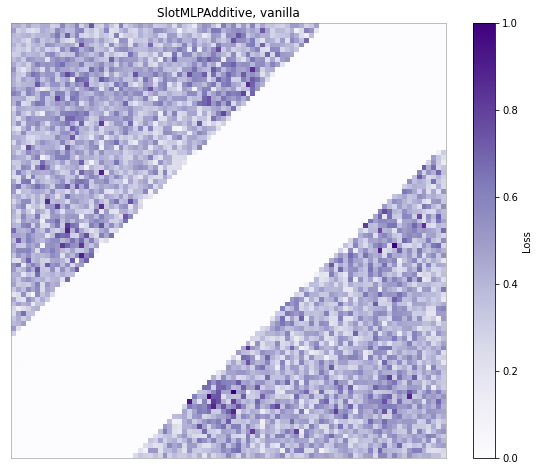

In [16]:
plot_heatmap([
    (
        x_id, y_id, calculate_mse(vanilla_slotmlpadditive[0], "mse_model"), False
    ),
    (
        x_ood, y_ood, calculate_mse(vanilla_slotmlpadditive[1], "mse_model"), False
    )
             ], 
    calculate_mse(vanilla_slotmlpadditive[1], "mse_model").max(),
    title="SlotMLPAdditive, vanilla", cmap="Purples"
)

In [21]:
plot_heatmap([
    (
        x_id, y_id, calculate_mse(vanilla_vanilla_slotattention[0], "mse_decoder"), False
    ),
    (
        x_ood, y_ood, calculate_mse(vanilla_vanilla_slotattention[1], "mse_decoder"), False
    )
             ], 
    calculate_mse(vanilla_vanilla_slotattention[1], "mse_decoder").max(),
    title="SlotAttention, vanilla decoder", cmap="Purples"
)

NameError: name 'vanilla_vanilla_slotattention' is not defined

In [22]:
plot_heatmap([
    (
        x_id, y_id, calculate_mse(vanilla_fixed_slotattention[0], "mse_decoder"), False
    ),
    (
        x_ood, y_ood, calculate_mse(vanilla_fixed_slotattention[1], "mse_decoder"), False
    )
             ], 
    calculate_mse(vanilla_vanilla_slotattention[1], "mse_decoder").max(),
    title="SlotAttention, fixed decoder", cmap="Purples"
)

NameError: name 'vanilla_vanilla_slotattention' is not defined

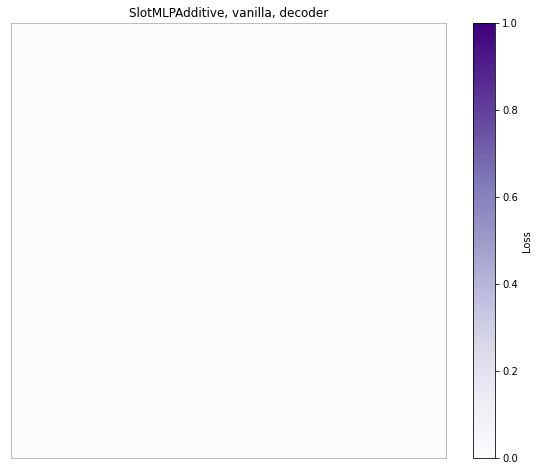

In [23]:
plot_heatmap([
    (
        x_id, y_id, calculate_mse(vanilla_slotmlpadditive[0], "mse_decoder"), False
    ),
    (
        x_ood, y_ood, calculate_mse(vanilla_slotmlpadditive[1], "mse_decoder"), False
    )
             ], 
    calculate_mse(vanilla_slotmlpadditive[1], "mse_model").max(),
    title="SlotMLPAdditive, vanilla, decoder", cmap="Purples"
)

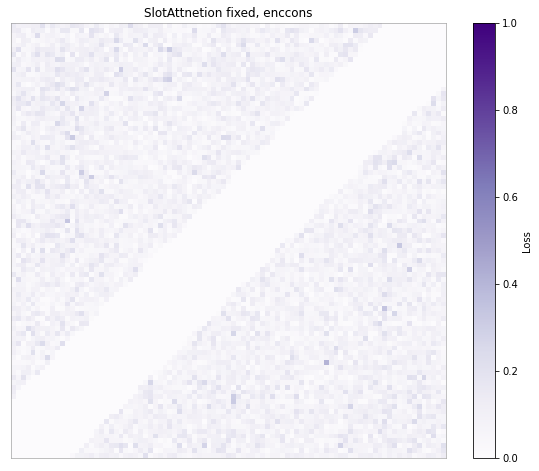

In [43]:
plot_heatmap([
    (
        x_id, y_id, calculate_mse(enccons_slotattention[0], "mse_model"), False
    ),
    (
        x_ood, y_ood, calculate_mse(enccons_slotattention[1], "mse_model"), False
    )
             ], 
    calculate_mse(vanilla_fixed_slotattention[1], "mse_model").max(),
    title="SlotAttnetion fixed, enccons", cmap="Purples"
)

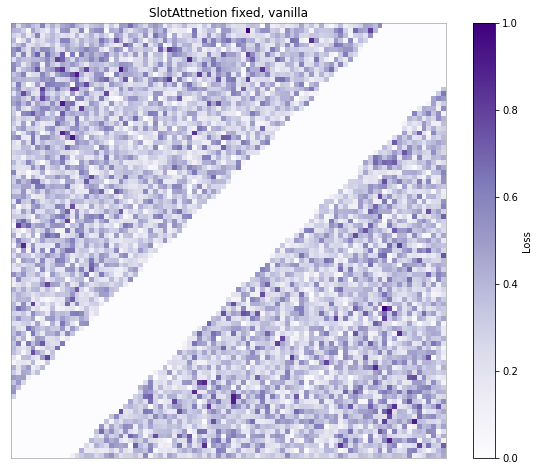

In [42]:
plot_heatmap([
    (
        x_id, y_id, calculate_mse(vanilla_fixed_slotattention[0], "mse_model"), False
    ),
    (
        x_ood, y_ood, calculate_mse(vanilla_fixed_slotattention[1], "mse_model"), False
    )
             ], 
    calculate_mse(vanilla_fixed_slotattention[1], "mse_model").max(),
    title="SlotAttnetion fixed, vanilla", cmap="Purples"
)

In [11]:
def plot_heatmap(data_sets, max_value, cmap='Purples', num_bins=90, title="Empty"):
    # Initialize lists to store x, y, and loss values
    x_all = []
    y_all = []
    loss_all = []

    # Iterate over the data sets
    for x, y, loss, exclude_region in data_sets:
        # Exclude points where abs(x - y) <= 0.125 if exclude_region is True
        if exclude_region:
            mask = np.abs(x - y) > 0.125
            x = x[mask]
            y = y[mask]
            loss = loss[mask]

        x_all.append(x)
        y_all.append(y)
        loss_all.append(loss)

    # Concatenate all x, y, and loss values
    x = np.concatenate(x_all)
    y = np.concatenate(y_all)
    loss = np.concatenate(loss_all)

    # Normalize the loss by the provided maximal value
    loss = loss / max_value

    # Define the bins for the x and y axes
    x_bins = np.linspace(min(x), max(x), num_bins)
    y_bins = np.linspace(min(y), max(y), num_bins)

    # Create a grid of mean loss values for each bin
    mean_loss_grid = np.zeros((num_bins - 1, num_bins - 1))
    for i in range(num_bins - 1):
        for j in range(num_bins - 1):
            in_bin = (x >= x_bins[i]) & (x < x_bins[i + 1]) & (y >= y_bins[j]) & (y < y_bins[j + 1])
            mean_loss_grid[j, i] = np.mean(loss[in_bin]) if np.any(in_bin) else np.nan
    
    fig, ax = plt.subplots(figsize=(10, 8))
    # Create the heatmap
    cax = ax.imshow(mean_loss_grid, origin='lower', cmap=cmap, vmin=0, vmax=1, aspect='equal')

    # Remove ticks and axis labels
    ax.set_xticks([])
    ax.set_yticks([])
#     ax.axis('off')

    # Add bounding box around the heatmap
    for spine in ax.spines.values():
        spine.set_visible(True)
        spine.set_color('gray')
        spine.set_linewidth(0.5) 



    fig.colorbar(cax, label='Loss')
    plt.title(title)
    plt.show()


In [55]:
paths = "D:/git_projects/bethgelab/lab_rotation/object_centric_ood/notebooks/models/SlotMLPAdditive_2obj_300_vanilla_no_overlaps"
paths_and_names = []
for name in os.listdir(paths):
    if name.endswith(".pt"):
        paths_and_names.append((os.path.join(paths, name), "SlotMLPAdditive"))


models = []
hooks = []
for (path, name) in paths_and_names:
    model, decoder_hook= load_model_and_hook(path, name)
    models.append(model)
    hooks.append(decoder_hook)

cast_models_to_device(models)    


seeds = [43]
SlotMLPAdditive_output = evaluate_function_over_seeds(calculate_decoder_optimality, 
                                                         seeds, traversed_dataset, 
                                                         diagonal_dataset_left, diagonal_dataset_right, 
                                                         models, hooks, device="cuda")
with open("models/slotmlpadditive_mse.pkl", "wb") as f:
    pickle.dump(SlotMLPAdditive_output, f)

tensor([[[0.6131, 0.3765, 0.0000, 0.0959, 0.0500],
         [0.6247, 0.6128, 1.0000, 0.1224, 0.1773]],

        [[0.8621, 0.7075, 0.0000, 0.1245, 0.0500],
         [0.5553, 0.5225, 1.0000, 0.1139, 0.1864]],

        [[0.6891, 0.2666, 1.0000, 0.1006, 0.0500],
         [0.5142, 0.5170, 0.0000, 0.1092, 0.1955]],

        ...,

        [[0.4077, 0.6953, 0.0000, 0.0937, 0.9500],
         [0.8450, 0.6073, 0.0000, 0.0960, 0.9318]],

        [[0.7945, 0.5575, 1.0000, 0.1252, 0.9500],
         [0.5209, 0.6336, 1.0000, 0.1251, 0.9409]],

        [[0.3819, 0.3873, 0.0000, 0.1082, 0.9500],
         [0.8087, 0.3198, 0.0000, 0.1109, 0.9500]]])

In [25]:

for i in range(5):
    local_copy = initial_id_latents
    data.SpriteWorldDataset(
    len(id_c_0_combinations),
    2,
    cfg,
    sample_mode="diagonal",
    no_overlap=True,
    delta=0.125,
    transform=transforms.Compose([transforms.ToPILImage(), transforms.ToTensor()]),
)

tensor([[[0.6274, 0.2786, 1.0000,  ..., 0.5644, 1.0000, 1.0000],
         [0.1688, 0.2812, 1.0000,  ..., 0.5575, 1.0000, 1.0000]],

        [[0.6826, 0.5678, 0.0000,  ..., 0.5101, 1.0000, 1.0000],
         [0.1994, 0.5209, 0.0000,  ..., 0.3843, 1.0000, 1.0000]],

        [[0.7012, 0.5609, 0.0000,  ..., 0.8419, 1.0000, 1.0000],
         [0.2112, 0.5390, 0.0000,  ..., 0.8852, 1.0000, 1.0000]],

        ...,

        [[0.2531, 0.4842, 0.0000,  ..., 0.2558, 1.0000, 1.0000],
         [0.5236, 0.4025, 0.0000,  ..., 0.2089, 1.0000, 1.0000]],

        [[0.5045, 0.6096, 0.0000,  ..., 0.1638, 1.0000, 1.0000],
         [0.1162, 0.6211, 0.0000,  ..., 0.3113, 1.0000, 1.0000]],

        [[0.6320, 0.7307, 0.0000,  ..., 0.7162, 1.0000, 1.0000],
         [0.2171, 0.7152, 0.0000,  ..., 0.7208, 1.0000, 1.0000]]])

In [26]:
len(ood_c_0_combinations)

7482

In [49]:
np.array((2060, 2044, 2057, 2056, 2031, 2035, 2029, 2024)) - 2023

array([37, 21, 34, 33,  8, 12,  6,  1])